
##Imports



In [ ]:
import random

import pandas as pd
import numpy as np
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, classification_report,
                             confusion_matrix)
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from transformers import AutoConfig

##Constants

In [ ]:
#  The name of the BERT model used
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
# The number of labels of the target variable
LABELS_NUMBER = 2

# The max lenght of text can be up to 512 for BERT
MAX_LENGHT = 512
#Hyperparamters of model
BATCH_SIZE = 6
LEARNING_RATE = 2e-5
EPOCHS_NUMBER = 10

N_PREDICTIONS_TO_SHOW = 10

In [ ]:
train_data = pd.read_csv('./train.csv')
print(train_data.shape)
train_data.head(3)

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [ ]:
# load test dataset
test_data = pd.read_csv('./test.csv')
print(test_data.shape)
test_data.head(3)

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [ ]:
for tweet_index in range(1,30,5):
    print(f'Text of the tweet: {train_data["text"][tweet_index]}')
    print(f'Target: {"Real disaster" if train_data["target"][tweet_index]==1 else "Not real disaster"}\n')

Text of the tweet: Forest fire near La Ronge Sask. Canada
Target: Real disaster

Text of the tweet: #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
Target: Real disaster

Text of the tweet: Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
Target: Real disaster

Text of the tweet: I love fruits
Target: Not real disaster

Text of the tweet: London is cool ;)
Target: Not real disaster

Text of the tweet: Was in NYC last week!
Target: Not real disaster



<Axes: ylabel='count'>

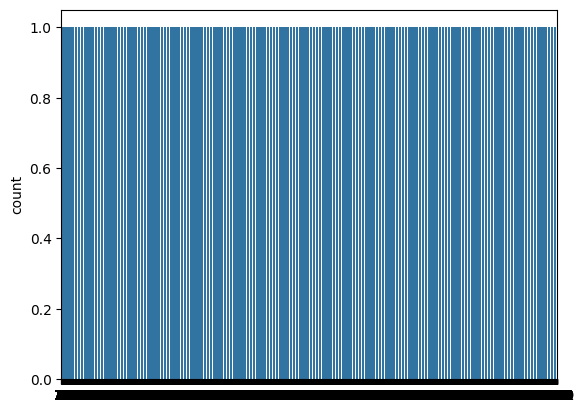

In [ ]:
sns.countplot(train_data["target"])

##Load bert tokenizer

In [ ]:
# Get the Bert tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME,
                                          do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Print some words of the vocabulary
vocabulary = tokenizer.get_vocab()
print(f'Size of the vocabulary: {len(vocabulary)}')
print(f'Some tokens of the vocabulary: {list(vocabulary.keys())[5000:5010]}')

Size of the vocabulary: 30522
Some tokens of the vocabulary: ['knight', 'lap', 'survey', 'ma', '##ow', 'noise', 'billy', '##ium', 'shooting', 'guide']


In [ ]:
def prepare_sequence(text):
    """
    Tokenize and prepare a sequence for the model. It tokenizes the text sequence
    adding special tokens ([CLS], [SEP]), padding  to the max length and truncate
    reviews longer than the max length.
    Return the token IDs, the segment IDs and the mask IDs.
    """

    prepared_sequence = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True,
                            max_length = MAX_LENGHT,
                            padding = 'max_length',
                            return_attention_mask = True
                            )
    return prepared_sequence

In [ ]:
# Prepare a test sentence
test_sentence = 'Is this jacksonville?'
test_sentence_encoded = prepare_sequence(test_sentence)
token_ids = test_sentence_encoded["input_ids"]
print(f'Test sentence:   {test_sentence}')
print(f'Keys:            {test_sentence_encoded.keys()}')
print(f'Tokens:          {tokenizer.convert_ids_to_tokens(token_ids)[:12]}')
print(f'Token IDs:       {token_ids[:12]}')
print(f'Segment IDs:     {test_sentence_encoded["token_type_ids"][:12]}')
print(f'Mask IDs         {test_sentence_encoded["attention_mask"][:12]}')
print(f'Input dimension: {len(token_ids)}')

Test sentence:   Is this jacksonville?
Keys:            dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
Tokens:          ['[CLS]', 'is', 'this', 'jacksonville', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Token IDs:       [101, 2003, 2023, 13057, 1029, 102, 0, 0, 0, 0, 0, 0]
Segment IDs:     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Mask IDs         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Input dimension: 512


In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    """
    Map to the expected input to TFBertForSequenceClassification.
    """
    mapped_example = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
    }
    return mapped_example, label

def encode_examples(texts_and_labels):
    """
    Prepare all sequences of text and build TF dataset.
    """

    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []

    for text, label in texts_and_labels:

        bert_input = prepare_sequence(text)

        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    # Create TF dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (input_ids_list, attention_mask_list, token_type_ids_list,
         label_list)
    )
    # Map to the expected input to TFBertForSequenceClassification
    dataset_mapped = dataset.map(map_example_to_dict)
    return dataset_mapped

In [ ]:
X = train_data["text"]
y = train_data["target"]

In [ ]:
# Split the training dataset for training and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,
                                                    random_state=1)

In [ ]:
n_training_examples = X_train.shape[0]
n_positive_training_examples = y_train.value_counts()[1]
n_negative_training_examples = y_train.value_counts()[0]
print(f'Number examples in training dataset: {n_training_examples}')
print(f'Number of positive examples in training dataset: {n_positive_training_examples}')
print(f'Number of negative examples in training dataset: {n_negative_training_examples}')

Number examples in training dataset: 6851
Number of positive examples in training dataset: 2947
Number of negative examples in training dataset: 3904


In [ ]:
train_dataset = list(zip(X_train, y_train))
val_dataset = list(zip(X_val, y_val))

In [ ]:
# Prepare sequences of text and build TF train dataset
ds_train_encoded = encode_examples(train_dataset).shuffle(10000).batch(BATCH_SIZE)

# Prepare sequences of text and build TF validation dataset
ds_val_encoded = encode_examples(val_dataset).batch(BATCH_SIZE)

In [ ]:
def get_model():
    # Define the configuration of the model
    config = AutoConfig.from_pretrained(PRETRAINED_MODEL_NAME,
                                        hidden_dropout_prob=0.2,
                                        num_labels=LABELS_NUMBER)
    # Model initialization
    model = TFBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME,
                                                            config=config)
    return model

In [ ]:
# Model initialization
model = get_model()

# Define the optimizer, the loss function and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Dealing with class imbalance here

In [ ]:
weight_for_0 = (1 / n_negative_training_examples)*(n_training_examples)/2.0
weight_for_1 = (1 / n_positive_training_examples)*(n_training_examples)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.88
Weight for class 1: 1.16


In [ ]:
# Train the model
model.fit(ds_train_encoded, epochs=EPOCHS_NUMBER, validation_data=ds_val_encoded,
          class_weight = class_weight)

Epoch 1/5


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1142/1142 [==============================] - 953s 758ms/step - loss: 0.4517 - accuracy: 0.7999 - val_loss: 0.4653 - val_accuracy: 0.7953
Epoch 2/5
1142/1142 [==============================] - 852s 746ms/step - loss: 0.3430 - accuracy: 0.8691 - val_loss: 0.4859 - val_accuracy: 0.8110
Epoch 3/5
1142/1142 [==============================] - 844s 739ms/step - loss: 0.2648 - accuracy: 0.9009 - val_loss: 0.5188 - val_accuracy: 0.8005
Epoch 4/5
1142/1142 [==============================] - 844s 739ms/step - loss: 0.1845 - accuracy: 0.9343 - val_loss: 0.6054 - val_accuracy: 0.7861
Epoch 5/5
1142/1142 [==============================] - 853s 747ms/step - loss: 0.1350 - accuracy: 0.9508 - val_loss: 0.7391 - val_accuracy: 0.7940


In [ ]:
# Get predictions in the validation dataset
val_predictions = model.predict(ds_val_encoded)
val_probabilities = softmax(val_predictions[0], axis=1)
y_val_predictions = np.argmax(val_probabilities, axis=1).flatten()  #returns the index of max value in an array

127/127 [==============================] - 42s 258ms/step


Area under the ROC curve: 0.8586518405772593
Classification metrics:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       438
           1       0.79      0.71      0.74       324

    accuracy                           0.79       762
   macro avg       0.79      0.78      0.79       762
weighted avg       0.79      0.79      0.79       762



Text(0.5, 1.0, 'Confusion matrix Validation set')

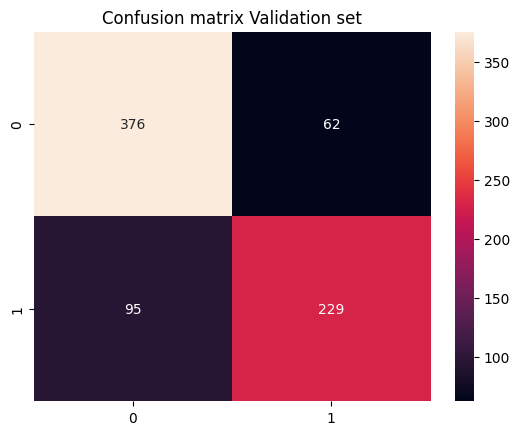

In [ ]:
# Compute metrics to evaluate the model
classification_metrics = classification_report(y_val, y_val_predictions)
# Compute the area under the ROC curve
area_under_the_curve = roc_auc_score(y_val, val_probabilities[:,1:2], multi_class="ovr")
# Compute the confusion matrix
error_matrix = confusion_matrix(y_val, y_val_predictions)
print(f'Area under the ROC curve: {area_under_the_curve}')
print(f'Classification metrics:\n{classification_metrics}')
# Plot the confusion matrix
ax = plt.axes()
sns.heatmap(error_matrix, annot=True, fmt="d")
ax.set_title('Confusion matrix Validation set')

In [ ]:
# Show some predictions in the validation dataset
X_test = test_data["text"]
for i in random.sample(range(len(val_dataset)), k=N_PREDICTIONS_TO_SHOW):
    print(f'\nText:       {X_test.values[i]}')
    print(f'Ground truth: {"Real disaster" if y_val.values[i]==1 else "Not real disaster"}')
    print(f'Predicted:    {"Real disaster" if y_val_predictions[i]==1 else "Not real disaster"}')


Text:       @margaretcho Call me a fag and I'm going to call you an ambulance :) #RainbowPower
Ground truth: Real disaster
Predicted:    Real disaster

Text:       .@ArneJungjohann #Energiewende is directly responsible for the collapse in energy value. http://t.co/NxvjPj610W
Ground truth: Real disaster
Predicted:    Not real disaster

Text:       Help fight Northern Corn Leaf Blight with Headline Amp https://t.co/LVoqPgkLI7
Ground truth: Real disaster
Predicted:    Real disaster

Text:       What if we used drones to help firefighters lead people out of burning buildings/ help put the fire out?
Ground truth: Real disaster
Predicted:    Real disaster

Text:       @EddieTrunk Blizzard of Ozz
Ground truth: Not real disaster
Predicted:    Not real disaster

Text:       Womens Flower Printed Shoulder Handbags Cross Body Metal Chain Satchel Bags Pink http://t.co/vBZqWzNxH7 http://t.co/NXIhHeP1Ea
Ground truth: Not real disaster
Predicted:    Not real disaster

Text:       BLOODY HELL TEEN WO

In [ ]:
def encode_test_examples(texts):
    """
    Prepare all sequences of text and build TF dataset.
    """

    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []

    for text in texts:

        bert_input = prepare_sequence(text)

        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])

    # Create TF dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (input_ids_list, attention_mask_list, token_type_ids_list)
    )
    # Map to the expected input to TFBertForSequenceClassification
    dataset_mapped = dataset.map(map_test_example_to_dict)
    return dataset_mapped

def map_test_example_to_dict(input_ids, attention_masks, token_type_ids):
    """
    Map to the expected input to TFBertForSequenceClassification.
    """
    mapped_example = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
    }
    return mapped_example

In [ ]:
X_test = test_data["text"]
test_dataset = list(X_test)
ds_test_encoded = encode_test_examples(test_dataset).batch(BATCH_SIZE)

In [ ]:
test_predictions = model.predict(ds_test_encoded)
test_probabilities = softmax(test_predictions[0], axis=1)
y_test_predictions = np.argmax(test_probabilities, axis=1).flatten()

544/544 [==============================] - 148s 257ms/step


In [ ]:
y_test_predictions

array([1, 1, 1, ..., 1, 1, 1])